## Anomaly Detection using Unsupervised methods

### Import the Requisite modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

#### Define the fraction of the data that is outliers here

In [2]:
outliers_fraction = 0.01

### Feature Engineering

Load the given data into a Pandas dataframe

In [3]:
df_orig = pd.read_csv('topline_metrics.csv')
del df_orig['Date.1']

Create a Copy of the Dataframe for making predictions. Also the data contains numerous entries for the same country, Date, and Platform i.e. duplicates, which are also removed in this step

In [4]:
df = df_orig.copy()
df.drop_duplicates(subset = ["Date",'Platform','Country'],keep=False, inplace = True)

The Country codes need to be ASCI compatible, for input to our models. Hence the Country names are trimmed/renamed so that they contain only English characters

In [5]:
chinese_map = {}
global_cnt = 0

In [6]:
def trim(s):
    idx = s.find('(')
    if(idx >= 0):
        ns = s[0:idx]
        ns = ns.strip()
        if(ns == 'Côte dIvoire'):
            return 'Cote dIvoire'
        return ns
    else:
        if(s in chinese_map.keys()):
            return chinese_map[s]
        else:
            ns = 'chinese_name_'+str(trim.counter)
            chinese_map[s] = ns
            trim.counter += 1
            return ns
trim.counter = 0

Creating other useful features from the given date information. Also it was observed that the Time spent field had negative entries, which doesnt make sense. Hence, these negative entries were made zero, to ensure consistency.

In [7]:
df['Country'] = df['Country'].apply(lambda x: trim(x))
df['Date'] =  pd.to_datetime(df['Date'])
df['dayofmonth'] = df.Date.dt.day
df['dayofyear'] = df.Date.dt.dayofyear
df['dayofweek'] = df.Date.dt.dayofweek
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year
df['weekofyear'] = df.Date.dt.weekofyear
df['is_month_start'] = (df.Date.dt.is_month_start).astype(int)
df['is_month_end'] = (df.Date.dt.is_month_end).astype(int)
df['weekend'] = ((df.Date.dt.dayofweek) // 5 == 1).astype(int)
df.loc[df['Time Spend Per Day(seconds)'] < 0,'Time Spend Per Day(seconds)'] = 0
df.reset_index(drop=True,inplace=True)

### K-Means Clustering

Standardize the data, and reduce the dimension down to 2, using Principal Component Analysis (PCA), so that we can plot our clusters

In [8]:
data = df[['TRU','DAU','Items','Trans','Conversion','Cash Flow','Return Customer','Time Spend Per Day(seconds)',
           'dayofweek','month','weekend','is_month_start','is_month_end']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

pca = PCA(n_components=2)
data = pca.fit_transform(data)

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Search for the best parameter for the number of clusters (K). Can also use Bayesian Information Criterion (BIC) here.

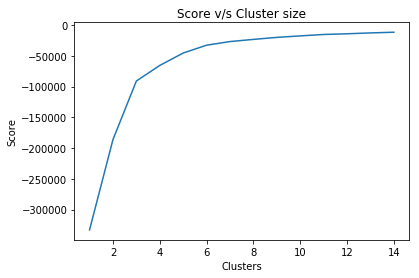

In [10]:
n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.xlabel('Clusters')
plt.ylabel('Score')
plt.title('Score v/s Cluster size')
plt.show()

We see that choosing the cluster size of 6, provides a good score while minimizing the number of parameters

In [11]:
df['cluster'] = kmeans[6].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0    60390
3    53855
1    46567
6     3920
2     1257
4      523
5       30
Name: cluster, dtype: int64

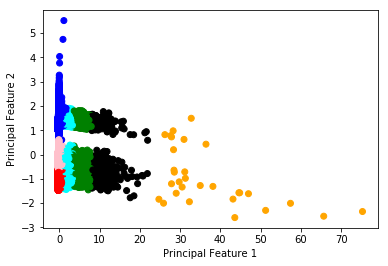

In [13]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.xlabel('Principal Feature 1')
plt.ylabel('Principal Feature 2')
plt.show()

We now construct the Euclidean Distance Matrix (EDM), by calculating the distance between all pairs of points. The Data points lying far away from the center of the cluster are labelled outliers

In [14]:
def getEDM(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

In [15]:
distance = getEDM(data, kmeans[6])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df['anomaly_kmeans'] = (distance >= threshold).astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


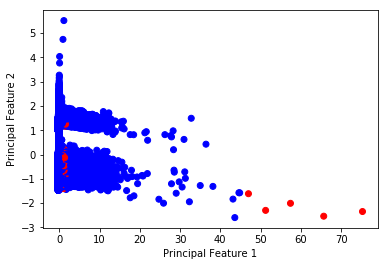

In [17]:
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly_kmeans"].apply(lambda x: colors[x]))
plt.xlabel('Principal Feature 1')
plt.ylabel('Principal Feature 2')
plt.show()

In the plot, the red colored data points, represent the anomalous data. The plot has been generated in a reduced dimension space, using PCA, so that we might be able to visualize the data.

We look at the plot for Transactions with respect to Dates. This would provide us a better idea, of the anomalous data points on the time scale

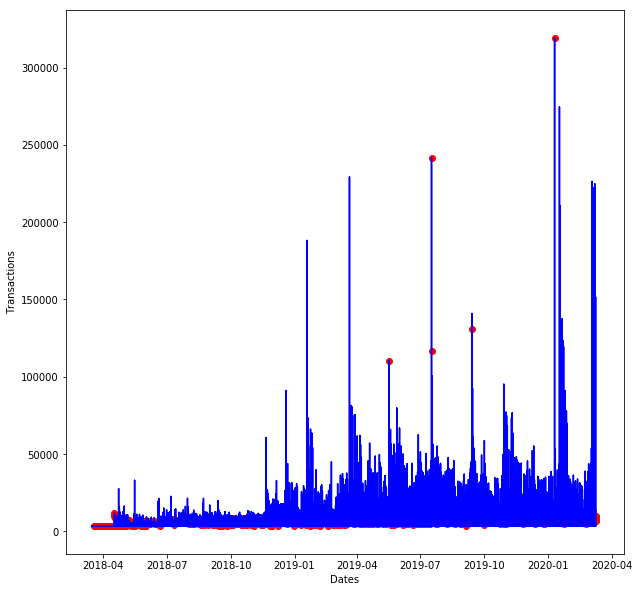

In [29]:
fig, ax = plt.subplots(figsize = (10,10))
a = df.loc[df['anomaly_kmeans'] == 1, ['Date', 'Trans']]
ax.plot(df['Date'], df['Trans'], color='blue')
times = [d.to_pydatetime() for d in a['Date']]
ax.scatter(times,a['Trans'], color='red')
plt.xlabel('Dates')
plt.ylabel('Transactions')
plt.show()

From the previous plot, we see that K-Means is not doing a good job of classifying the anomalous points. It has labelled few of the spikes in the time series data as anomalous. But, most of the anomalous data that it has classified correpond to the lowest transaction values, which kind of makes sense. But it order to be a robust Anomaly classifier, it has to account for the the spikes in the time series data. The gravity of the performance, can be felt, when we only consider the time series data for Transactions in United States, on ALL platforms. 

In [30]:
tmp = df.loc[((df['Country'] == 'United States') & (df['Platform'] == 'ALL')), \
             ['Date', 'Trans','anomaly_kmeans']].reset_index()
del tmp['index']
tmp.head()

,Date,Trans,anomaly_kmeans
0,2018-03-16,3428.09,0
1,2018-03-19,3428.09,1
2,2018-03-25,3428.09,0
3,2018-03-30,3428.09,0
4,2018-03-31,3428.09,0


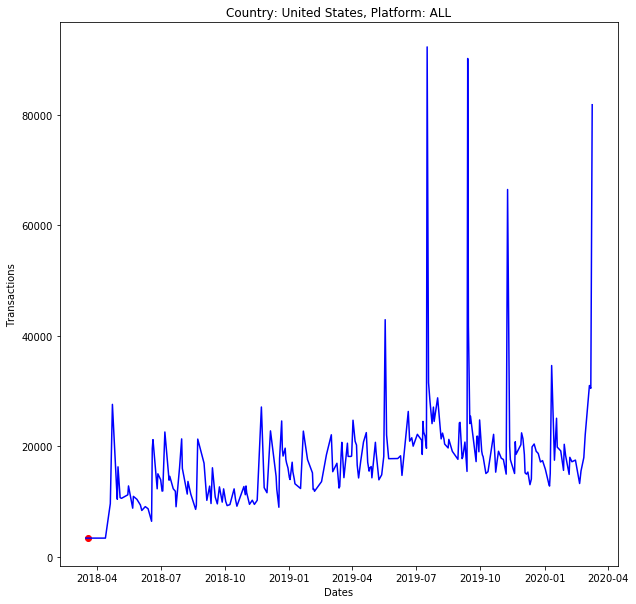

In [31]:
fig, ax = plt.subplots(figsize = (10,10))

a = tmp.loc[tmp['anomaly_kmeans'] == 1, ['Date', 'Trans']]

ax.plot(tmp['Date'], tmp['Trans'], color='blue')
times = [d.to_pydatetime() for d in a['Date']]
ax.scatter(times,a['Trans'], color='red')
plt.xlabel('Dates')
plt.ylabel('Transactions')
plt.title('Country: United States, Platform: ALL')
plt.show()

Only one point has been detected, which highlights the shortcomings of the Model !!

### Isolation Forest

Isolation Forest is similar in approach to Random Forest, in that it uses Decision Trees for Classification. But Isolation Forest makes use of the fact that anomalous data, comes from a different distribution, and hence are more easily seperated into leaf nodes. This translates to the fact that Anomalous data points are present in the Leaf nodes at the earlier levels of the tree.

The data is standardized first, before we start creating an Isolation forest

In [32]:
data = df[['Trans','dayofweek','month','weekend','is_month_start','is_month_end']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)

df['anomaly_IF'] = pd.Series(model.predict(data))
df['anomaly_IF'] = df['anomaly_IF'].map( {1: 0, -1: 1} )
print(df['anomaly_IF'].value_counts())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    164877
1      1665
Name: anomaly_IF, dtype: int64


We look at the plot for Transactions with respect to Dates. This would provide us a better idea, of the anomalous data points on the time scale

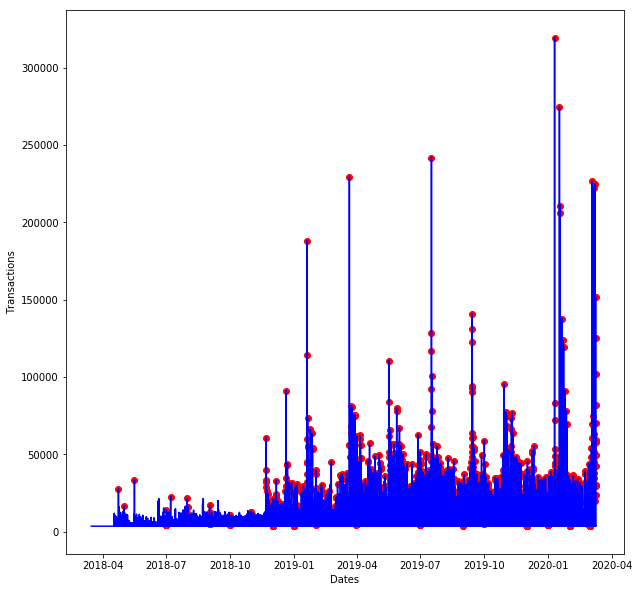

In [33]:
fig, ax = plt.subplots(figsize = (10,10))

a = df.loc[df['anomaly25'] == 1, ['Date', 'Trans']]

ax.plot(df['Date'], df['Trans'], color='blue')
times = [d.to_pydatetime() for d in a['Date']]
ax.scatter(times,a['Trans'], color='red')
plt.xlabel('Dates')
plt.ylabel('Transactions')
plt.show()

We see that Isolation Forest, has done a good job in categorizing the anomalous data points, and captures both the highs and lows in the time series plot. We now look at the model under a microscope, by judging its performance on United States on ALL platforms

In [34]:
tmp = df.loc[((df['Country'] == 'United States') & (df['Platform'] == 'ALL')), \
             ['Date', 'Trans','anomaly25']].reset_index()
del tmp['index']
tmp.head()

,Date,Trans,anomaly25
0,2018-03-16,3428.09,0
1,2018-03-19,3428.09,0
2,2018-03-25,3428.09,0
3,2018-03-30,3428.09,0
4,2018-03-31,3428.09,0


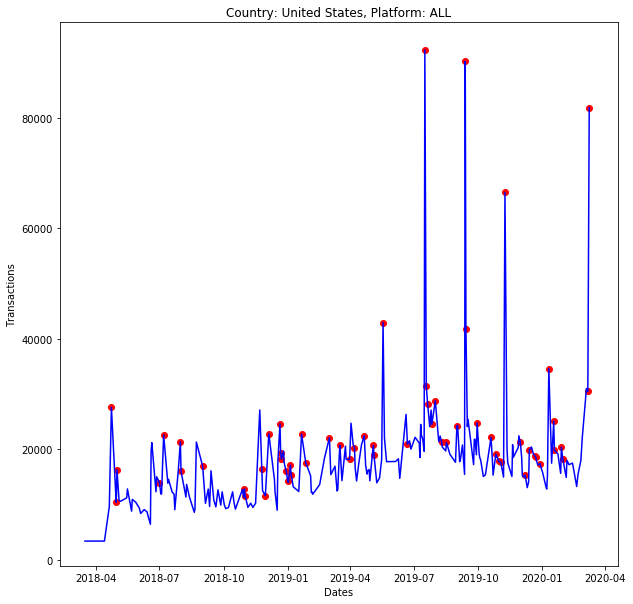

In [35]:
fig, ax = plt.subplots(figsize = (10,10))

a = tmp.loc[tmp['anomaly25'] == 1, ['Date', 'Trans']]

ax.plot(tmp['Date'], tmp['Trans'], color='blue')
times = [d.to_pydatetime() for d in a['Date']]
ax.scatter(times,a['Trans'], color='red')
plt.xlabel('Dates')
plt.ylabel('Transactions')
plt.title('Country: United States, Platform: ALL')
plt.show()

We see that Isolation Forest, is better able to capture anomalous data points, as it has captured the spikes in the time series data for transactions as anomalies. Hence, we will use the Isolation Forest model, to perform Anomaly detection on our time series data.